In [ ]:
# 1. Import thư viện cần thiết ~33s
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
df = pd.read_csv(company_csv)
df

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,5980,6240,5980,6240,50,VMD
1,1,2014-01-03,6240,6240,6240,6240,100,VMD
2,2,2014-01-06,6340,6340,6340,6340,860,VMD
3,3,2014-01-07,6340,6340,6340,6340,0,VMD
4,4,2014-01-08,6090,6340,6090,6340,200,VMD
...,...,...,...,...,...,...,...,...
2472,2472,2023-12-04,20300,20300,19700,20300,238300,VMD
2473,2473,2023-12-05,20300,20900,19750,19900,62700,VMD
2474,2474,2023-12-06,20300,20600,20100,20150,51500,VMD
2475,2475,2023-12-07,20150,20300,20000,20150,41100,VMD


In [ ]:
# và gắng index với giá Close cho df1
df1 = df.reset_index()['close']
df1

0        6240
1        6240
2        6340
3        6340
4        6340
        ...  
2472    20300
2473    19900
2474    20150
2475    20150
2476    20050
Name: close, Length: 2477, dtype: int64

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
# scaler
df1

array([[0.00139528],
       [0.00139528],
       [0.00279057],
       ...,
       [0.19547928],
       [0.19547928],
       [0.194084  ]])

In [ ]:
# 4. Chia train test 7 - 2 - 1 len() = 2467 => 7 - 2 - 1 = 1726 493 248
train_size = int(0.7 * len(df1)) #1726
test_size = int(0.2 * len(df1)) #493
val_size = len(df1) - train_size - test_size #248

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# print(train_size , test_size , val_size)
# print(train_data)
# print(test_data)
# print(val_data)

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 [==============================] - 10s 191ms/step - loss: 0.0042 - val_loss: 0.0165
Epoch 2/100
26/26 [==============================] - 5s 211ms/step - loss: 7.3257e-04 - val_loss: 0.0089
Epoch 3/100
26/26 [==============================] - 4s 158ms/step - loss: 2.9177e-04 - val_loss: 0.0082
Epoch 4/100
26/26 [==============================] - 4s 145ms/step - loss: 2.7548e-04 - val_loss: 0.0078
Epoch 5/100
26/26 [==============================] - 4s 162ms/step - loss: 2.6237e-04 - val_loss: 0.0073
Epoch 6/100
26/26 [==============================] - 5s 203ms/step - loss: 2.5343e-04 - val_loss: 0.0071
Epoch 7/100
26/26 [==============================] - 4s 144ms/step - loss: 2.4378e-04 - val_loss: 0.0066
Epoch 8/100
26/26 [==============================] - 5s 215ms/step - loss: 2.2850e-04 - val_loss: 0.0062
Epoch 9/100
26/26 [==============================] - 5s 211ms/step - loss: 2.3329e-04 - val_loss: 0.0062
Epoch 10/100
26/26 [==============================] - 4s 1

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 28ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_train, ytest,yval về lại VND
y_train = y_train.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)
yval = yval.reshape(-1, 1)

y_train = scaler.inverse_transform(y_train)
ytest = scaler.inverse_transform(ytest) #actual value
yval = scaler.inverse_transform(yval) #acutual value

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# def evaluateModel(validate, testt)
#   valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
#   test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
#   print('Validation RMSE:', valid_rmse)
#   print('Testing RMSE:', test_rmse)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MAE, RMSE, R-square cho testing
mae_test = mean_absolute_error(ytest, y_pred)
rmse_test = np.sqrt(mean_squared_error(ytest, y_pred))
mape_test = calculate_mape(ytest, y_pred)
r_squared_test = r2_score(ytest, y_pred)

# Tính MAE, RMSE cho validation
mae_val = mean_absolute_error(yval, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(yval, y_pred_val))
mape_val = calculate_mape(yval, y_pred_val)
r_squared_val = r2_score(yval, y_pred_val)

# In kết quả
print('---------VALIDATE----------')
print("MAE:", round(mae_val, 3))
print("RMSE:", round(rmse_val, 3))
print("MAPE:", round(mape_val, 3))
print("R-squared:", round(r_squared_val, 3))
print('--------------------------')
print('---------TEST----------')
print("MAE:", round(mae_val, 3))
print("RMSE:", round(rmse_test, 3))
print("MAPE:", round(mape_test, 3))
print("R-squared:", round(r_squared_test, 3))
print('-------------------')


---------VALIDATE----------
MAE: 333.847
RMSE: 485.469
MAPE: 1.577
R-squared: 0.968
--------------------------
---------TEST----------
MAE: 333.847
RMSE: 1766.212
MAPE: 3.334
R-squared: 0.971
-------------------


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=188
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.20315334 0.22268732 0.24361658 0.26663876 0.28338217 0.26454584
 0.27012697 0.26873169 0.27012697 0.26384819 0.25198828 0.26175527
 0.25198828 0.26175527 0.27012697 0.29454444 0.27570811 0.27012697
 0.27570811 0.26524348 0.2589647  0.25617413 0.26315055 0.26315055
 0.25617413 0.2673364  0.26315055 0.26175527 0.26245291 0.26175527
 0.26315055 0.26315055 0.27012697 0.26594112 0.26594112 0.26035998
 0.2673364  0.26524348 0.26454584 0.26175527 0.26105763 0.26315055
 0.25617413 0.27012697 0.26035998 0.26594112 0.26524348 0.26454584
 0.26175527 0.26454584 0.26454584 0.26594112 0.26245291 0.26245291
 0.26245291 0.25617413 0.2589647  0.26315055 0.25617413 0.24919771
 0.26594112 0.26245291 0.26873169 0.26454584 0.26454584 0.2589647
 0.2589647  0.25129064 0.25617413 0.25338356 0.24919771 0.25477885
 0.24919771 0.250593   0.24850007 0.24919771 0.24780243 0.23594251
 0.24082601 0.23873308 0.23384959 0.23384959 0.23524487 0.23175666
 0.22826845 0.22826845 0.22826845 0.23036138 0.2310

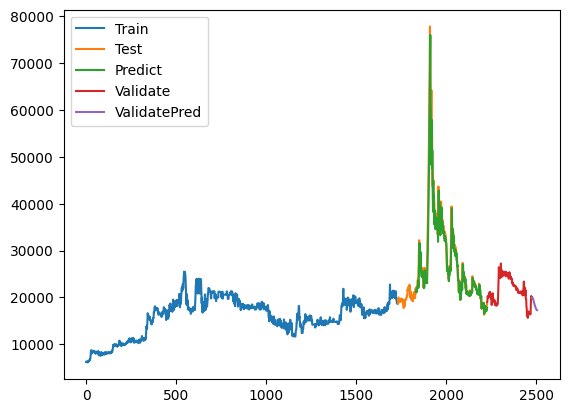

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
# plt.figure(figsize=(5,5))
plt.show()